In [18]:
# %python3 -m pip install -r requirements.txt
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd

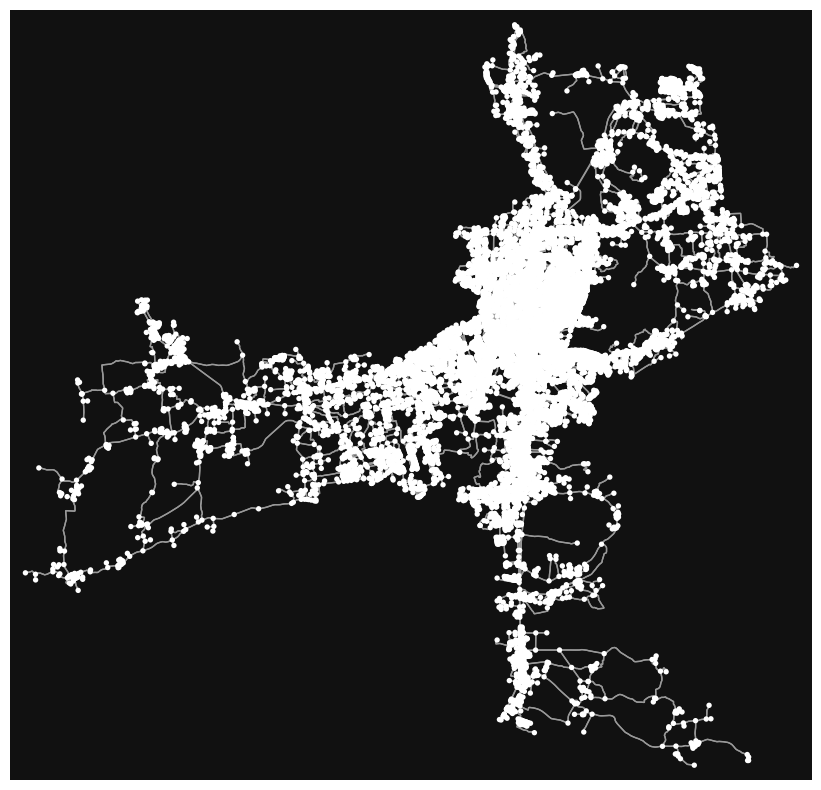

In [13]:
place_name = "Hat Yai District, Songkhla, Thailand"
def load_graph():
    return ox.graph_from_place(place_name, network_type='drive')

graph = load_graph()
fig, ax = ox.plot_graph(graph, figsize=(12, 10))

In [14]:
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [15]:
edges.columns

Index(['osmid', 'highway', 'oneway', 'ref', 'reversed', 'length', 'name',
       'geometry', 'lanes', 'bridge', 'maxspeed', 'junction', 'access',
       'tunnel'],
      dtype='object')

In [ ]:
# Get nodes and edges as GeoDataFrames
nodes, edges = ox.graph_to_gdfs(graph)

print(f"Network Statistics:")
print(f"Number of nodes: {len(nodes)}")
print(f"Number of edges: {len(edges)}")
print(f"\nNodes columns: {list(nodes.columns)}")
print(f"\nEdges columns: {list(edges.columns)}")

# Check the bounds of the network
bounds = nodes.total_bounds
print(f"\nNetwork bounds (lon_min, lat_min, lon_max, lat_max): {bounds}")
print(edges['length'])
# Export nodes and edges to CSV files
nodes_csv = nodes.copy()
# Convert geometry to separate lat/lon columns for CSV export
nodes_csv['longitude'] = nodes_csv.geometry.x
nodes_csv['latitude'] = nodes_csv.geometry.y
nodes_csv = nodes_csv.drop('geometry', axis=1)

edges_csv = edges.copy()
# Drop geometry column for CSV export as it's complex
edges_csv = edges_csv.drop('geometry', axis=1)

# Export to CSV
nodes_csv.to_csv('data/raw/road/hatyai_nodes.csv', index=True)
edges_csv.to_csv('data/raw/road/hatyai_edges.csv', index=True)

print(f"\nExported data:")
print(f"Nodes exported to 'hatyai_nodes.csv' ({len(nodes_csv)} records)")
print(f"Edges exported to 'hatyai_edges.csv' ({len(edges_csv)} records)")


Network Statistics:
Number of nodes: 17062
Number of edges: 39268

Nodes columns: ['y', 'x', 'highway', 'street_count', 'junction', 'geometry']

Edges columns: ['osmid', 'highway', 'oneway', 'ref', 'reversed', 'length', 'name', 'geometry', 'lanes', 'bridge', 'maxspeed', 'junction', 'access', 'tunnel']

Network bounds (lon_min, lat_min, lon_max, lat_max): [100.2346511   6.8057655 100.6019448   7.1558113]
u            v            key
485546733    620882137    0       20.101836
             1196108922   0       44.387870
485546740    9038239468   0       46.536981
             8635005966   0       67.706242
             1235108927   0      156.767445
                                    ...    
13440459319  13440459320  0       50.802856
             10961281135  0       50.805061
13440459320  10961281130  0       72.578754
             13440459319  0       50.802856
             10961281132  0       47.699785
Name: length, Length: 39268, dtype: float64

Exported data:
Nodes exported to '

In [ ]:
nodes = pd.read_csv('data/raw/road/hatyai_nodes.csv')
edges = pd.read_csv('data/raw/road/hatyai_edges.csv')

/var/folders/wk/qkt4jd3144lcc_q05d6x6h7m0000gn/T/ipykernel_39413/2731768590.py:2: DtypeWarning: Columns (10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  edges = pd.read_csv('hatyai_edges.csv')


In [ ]:
# Load flood grid data (lon=x, lat=y)
flood = pd.read_csv("dat/raw/flood/rd2_20251126_1800.csv")


# Build GeoDataFrames for nearest-neighbor join
flood_gdf = gpd.GeoDataFrame(
    flood,
    geometry=gpd.points_from_xy(flood.x, flood.y),
    crs="EPSG:4326",
)
nodes_gdf = gpd.GeoDataFrame(
    nodes.copy(),
    geometry=gpd.points_from_xy(nodes.x, nodes.y),
    crs="EPSG:4326",
)

# Attach nearest flood gridcode to each node
nodes_nearest = gpd.sjoin_nearest(
    nodes_gdf,
    flood_gdf[["gridcode", "geometry"]],
    how="left",
    distance_col="flood_distance_deg",
)
nodes_nearest["flood_level"] = nodes_nearest["gridcode"]
nodes_with_flood = nodes_nearest.drop(columns=["index_right"])

# Propagate flood level to edges using the max of endpoint levels
node_flood = nodes_with_flood.set_index("osmid")["flood_level"]
edges_with_flood = edges.copy()
edges_with_flood["flood_level_u"] = edges_with_flood["u"].map(node_flood)
edges_with_flood["flood_level_v"] = edges_with_flood["v"].map(node_flood)
edges_with_flood["flood_level"] = edges_with_flood[["flood_level_u", "flood_level_v"]].max(axis=1)

# Save results
nodes_with_flood.drop(columns=["geometry"]).to_csv("data/clean/hatyai_nodes_flood.csv", index=False)
edges_with_flood.to_csv("data/clean/hatyai_edges_flood.csv", index=False)

print("Flood attributes attached:")
print(nodes_with_flood[["osmid", "flood_level"]].head())
print(edges_with_flood[["u", "v", "flood_level"]].head())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/array.py:417: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Flood attributes attached:
       osmid  flood_level
0  485546733            1
1  485546740            1
2  485546745            1
3  485546747            5
4  485546759            5
           u           v  flood_level
0  485546733   620882137            1
1  485546733  1196108922            3
2  485546740  9038239468            1
3  485546740  8635005966            1
4  485546740  1235108927            2
